In [1]:
import sys
import os

sys.path.append(os.path.abspath('../'))
from Point_Cloud_Registration.utilities import  *
import pyrealsense2 as rs
import numpy as np
import cv2
from utilites import *
import apriltag
import matplotlib.pyplot as plt
from D435i import D435i

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [10]:
pcd_cloud = []
#读取点云
for i in range(6):
    filename = f"output/point_cloud_{i+1}.ply"
    pcd_cloud.append(o3d.io.read_point_cloud(filename))
    

In [15]:
voxel_size = 5
base_cloud = None
# base_cloud = pcd_cloud[0]
# base_cloud = removed_plane(base_cloud)
modified_cloud = []
for pcd in pcd_cloud[0:3]:
    if not base_cloud:
        print(True)
        base_cloud = pcd
        base_cloud,_ = base_cloud.remove_radius_outlier(nb_points=50, radius=10)
        base_cloud = removed_plane(base_cloud)
        target_down, target_fpfh = preprocess_point_cloud(base_cloud, voxel_size)
        modified_cloud.append(target_down)
    else:
        pcd,_ = pcd.remove_radius_outlier(nb_points=50, radius=10)
        pcd = removed_plane(pcd)
        source_down, source_fpfh = preprocess_point_cloud(pcd, voxel_size)
        result = execute_global_registration(source_down, target_down, source_fpfh, target_fpfh, voxel_size, iteration=1000000)
        trans = result.transformation
        source_down.transform(trans)
        reg = icpRegistration(source_down, target_down, threshold= 0.0005, iteration=10000)
        print(reg.fitness)
        print(trans)
        trans = reg.transformation
        source_down.transform(trans)
        modified_cloud.append(source_down)
        base_cloud = source_down
        target_down, target_fpfh = preprocess_point_cloud(source_down, voxel_size)
base_cloud = base_cloud.voxel_down_sample(5)
o3d.visualization.draw_geometries(modified_cloud)

True
0.0
[[-8.82811421e-01  4.67658070e-01  4.40445784e-02  4.03874643e+02]
 [ 4.56273082e-01  8.31465587e-01  3.16985571e-01 -1.01842088e+02]
 [ 1.11619309e-01  2.99934838e-01 -9.47407105e-01 -3.91878865e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
0.0
[[-2.83965747e-01  9.58258100e-01  3.32395640e-02  3.89365469e+02]
 [ 9.57796860e-01  2.85100263e-01 -3.66471704e-02 -1.13349680e+02]
 [-4.45940564e-02  2.14302089e-02 -9.98775308e-01 -3.94292970e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


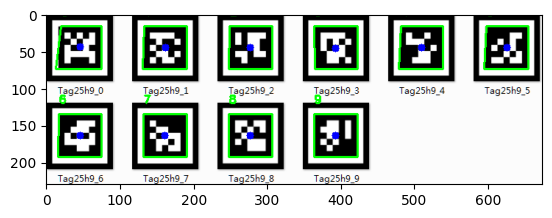

In [4]:
frame = cv2.imread('apriltag.png')
detect = detector(families='tag25h9')
gray_img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
tags = get_tags(detect, gray_img)
frame = draw_tags_box(tags, frame)
plt.imshow(frame)